In [153]:
import gograph
import similarity
import importlib
import re
import time
import annotations

import pandas as pd
import numpy as np
import scipy

In [944]:
pd.options.display.max_rows = 50

In [969]:
def reload_my_modules():
    """Re-import my modules into the IPython shell"""
    importlib.reload(annotations)
    importlib.reload(gograph)
    importlib.reload(similarity)
    importlib.reload(diffusion)

In [8]:
%%time
reload_my_modules()
fp = 'data/goa_human.gaf'
anno = annotations.Annotations(fp)

/usr/local/lib/python3.7/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 1.28 s, sys: 180 ms, total: 1.46 s
Wall time: 1.48 s


In [9]:
# num proteins
print(anno.annotations.groupby('DB_Object_ID').size().count())
# num annos per protein
print(anno.annotations.groupby('DB_Object_ID').size().mean())
#
print(anno.annotations.groupby('DB_Object_ID').size().quantile([0, 0.25, 0.5, 0.75, 1]))
# total annos
print(len(anno.annotations))

19626
25.621216753286458
0.00      1.0
0.25      7.0
0.50     15.0
0.75     30.0
1.00    914.0
dtype: float64
502842


In [10]:
%%time
reload_my_modules()
fp = 'data/go-basic.obo'
#fp = 'data/gene_ontology_edit.obo.2019-07-01'
ontology = gograph.OBOParser(fp).parse_ontology()

CPU times: user 2.35 s, sys: 133 ms, total: 2.48 s
Wall time: 2.52 s


In [11]:
t = time.time()
ontology.make_ancestry_matrix()
print(time.time()-t)

10.222615718841553


In [12]:
ontology.ancestry_matrix.matrix.setdiag(1)

In [13]:
anno.annotations = anno.annotations.loc[anno.annotations.Aspect == 'P', :]

In [14]:
len(anno.annotations)

164407

In [15]:
importlib.reload(annotations)
ft = annotations.FrequencyTable(anno, ontology.ancestry_matrix)

/Users/ilyanovikov/Documents/CodeRepos/ggid/annotations.py:52: RuntimeWarning: divide by zero encountered in log10
  self.information_content = -1*np.log10(self.deep_count.sum(axis=0)/self.deep_count.sum())


In [216]:
p = pd.read_csv('data/list_of_human_kinases.csv')
p.head()

,Unnamed: 0,gene_symbol,gene_synonym,uniprot
0,0,AKT1,AKT1,P31749
1,1,AKT2,AKT2,P31751
2,2,AKT3,AKT3,Q9Y243
3,3,CDC42BPA,MRCKA,Q5VT25
4,4,CDC42BPB,MRCKB,Q9Y5S2


(array([   0., 2374., 2116., 1893., 1508., 1230., 1138.,  968.,  757.,
         721.,  555.,  496.,  402.,  375.,  283.,  272.,  236.,  211.,
         384.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

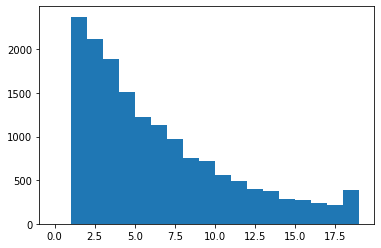

In [659]:
plt.hist([len(v) for k, v in sim.annotations2.items()], bins = range(20))

In [800]:
reload_my_modules()

#P25098 GRK2
#P35626 GRK3

sim = similarity.Similarity(anno, ontology, ft, list(p.gene_symbol), namespace='P', verbose=True)
#sim = similarity.Similarity(anno, ontology, ft, p53_kin_exist, namespace='P', verbose=True)

sim.sanitize_protein_list()

print(len(sim.proteins))
sim.calculate_similarity()

512
322


In [801]:
sim.sim_matrix.sim_matrix.shape

(322, 322)

In [802]:
sim.sim_matrix.sim_matrix

matrix([[0.        , 2.99633872, 2.93881343, ..., 2.61262591, 2.73961511,
         2.43941017],
        [2.99633872, 0.        , 3.01200228, ..., 2.50502385, 2.79258966,
         2.75982686],
        [2.93881343, 3.01200228, 0.        , ..., 2.38865585, 2.66963176,
         2.45458783],
        ...,
        [2.61262591, 2.50502385, 2.38865585, ..., 0.        , 2.69993225,
         2.25119833],
        [2.73961511, 2.79258966, 2.66963176, ..., 2.69993225, 0.        ,
         2.95760666],
        [2.43941017, 2.75982686, 2.45458783, ..., 2.25119833, 2.95760666,
         0.        ]])

In [825]:
sim.sim_matrix.threshold_matrix(10)
print(len(sim.sim_matrix.adj_matrix.nonzero()[0]))
#sim.sim_matrix.adj_matrix.todense()

3221


In [814]:
for row in range(len(sim.sim_matrix.adj_matrix)):
    print(sim.sim_matrix.adj_matrix[row,:].sum())

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
11.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


In [815]:
mask = sim.sim_matrix.adj_matrix.sum(axis=1) > 50
for i, flag in enumerate(mask):
    if flag:
        sim.sim_matrix.adj_matrix[i, :] = 0
        sim.sim_matrix.adj_matrix[:, i] = 0   
#sim.sim_matrix.sim_matrix[511, :] = 0

In [816]:
for row in range(len(sim.sim_matrix.adj_matrix)):
    print(sim.sim_matrix.adj_matrix[row,:].sum())

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
11.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


In [805]:
sim.sim_matrix.adj_matrix[26,:].sum()

10.0

In [934]:
sim.sim_matrix.save_as_pickle('results/kinase_matrix.pkl')

In [818]:
p53_kin = ['CSNK2A1', 'CDK1', 'PRKDC', 'CDK2', 'MAPK8', 'CDK7',
           'CSNK1D', 'MAPK9', 'EIF2AK2', 'CHEK1', 'CHEK2', 'GSK3B',
           'MAPK1', 'PLK3','AURKA', 'TAF1', 'RPS6KA3', 'CDK9', 'CDK5',
           'DYRK2', 'HIPK2', 'IKBKB', 'TTK', 'AURKB', 'CSNK1A1', 'RPS6KA1']

In [823]:
sim.sim_matrix.adj_matrix = sim.sim_matrix.adj_matrix + sim.sim_matrix.adj_matrix.T
sim.sim_matrix.adj_matrix[sim.sim_matrix.adj_matrix > 1] = 1 

In [826]:
import cross_validation
import diffusion
importlib.reload(diffusion)
importlib.reload(cross_validation)

p53_kin_exist = [p for p in p53_kin if p in sim.sim_matrix.protein_list]
#p53_kin_exist = ['CDK1', 'CDK2', 'CDK7', 'CDK9', 'CDK5']
#p53_kin_exist = ['ABL1', 'ABL2', 'AKT1', 'CDK2', 'CDK7', 'CDK9', 'CDK5']
print(p53_kin_exist)
loo = cross_validation.LOOValitation(sim.sim_matrix, p53_kin_exist)

res = loo.run_validation()
loo.get_auc()

['CSNK2A1', 'CDK1', 'PRKDC', 'CDK2', 'MAPK8', 'CDK7', 'CSNK1D', 'MAPK9', 'EIF2AK2', 'CHEK1', 'CHEK2', 'GSK3B', 'MAPK1', 'PLK3', 'AURKA', 'RPS6KA3', 'CDK9', 'CDK5', 'DYRK2', 'HIPK2', 'IKBKB', 'TTK', 'AURKB', 'CSNK1A1', 'RPS6KA1']
CSNK2A1 0.005218929038184375
CDK1 0.005145207355333395
PRKDC 0.00496255706622199
CDK2 0.010260178005656963
MAPK8 1.8409420529951718e-05
CDK7 0.01042557977319635
CSNK1D 0.005034610837204381
MAPK9 0.005218994694534552
EIF2AK2 0.0023915957453964467
CHEK1 0.0076535493914792595
CHEK2 0.012761681846811252
GSK3B 0.007340678087644755
MAPK1 1.925236983783306e-05
PLK3 0.007715068747516015
AURKA 0.010087658035035424
RPS6KA3 0.00529245525369361
CDK9 0.005268041546450196
CDK5 0.0024897447342973485
DYRK2 0.004949075079762255
HIPK2 0.0025142941100277524
IKBKB 1.842386149438519e-05
TTK 0.005077666434627398
AURKB 0.007500229158036483
CSNK1A1 0.005200538406357736
RPS6KA1 0.0026554503611679182
{'CSNK2A1': 0.005218929038184375, 'CDK1': 0.005145207355333395, 'PRKDC': 0.004962557066

0.8704377104377105

In [827]:
res['zscore'] = scipy.stats.zscore(res.avg_label)
res['rank'] = res.zscore.rank(ascending=False)
res.loc[res.label==1]

,protein_name,avg_label,label,zscore,rank
17,AURKA,0.010088,1,3.261187,6.0
18,AURKB,0.007500,1,2.244267,13.0
43,CDK1,0.005145,1,1.318688,28.0
48,CDK2,0.010260,1,3.328991,4.0
50,CDK5,0.002490,1,0.275030,80.0
52,CDK7,0.010426,1,3.393998,3.0
53,CDK9,0.005268,1,1.366965,24.0
55,CHEK1,0.007654,1,2.304525,10.0
56,CHEK2,0.012762,1,4.312140,1.0
61,CSNK1A1,0.005201,1,1.340435,27.0


In [994]:
p53_kin_exist

['CSNK2A1',
 'CDK1',
 'PRKDC',
 'CDK2',
 'MAPK8',
 'CDK7',
 'CSNK1D',
 'MAPK9',
 'EIF2AK2',
 'CHEK1',
 'CHEK2',
 'GSK3B',
 'MAPK1',
 'PLK3',
 'AURKA',
 'RPS6KA3',
 'CDK9',
 'CDK5',
 'DYRK2',
 'HIPK2',
 'IKBKB',
 'TTK',
 'AURKB',
 'CSNK1A1',
 'RPS6KA1']

In [1015]:


reload_my_modules()
dif = diffusion.Diffusion(sim.sim_matrix, ['CDK1'])
res = dif.diffuse()
df = res.get_as_pandas_df_without_labels()
df.head(10)

hi


,protein,initial_label,final_label,zscore,rank
16,ATR,0.0,0.002611,6.853286,1.0
41,CDC42BPB,0.0,0.002611,6.853286,2.0
32,BUB1B,0.0,0.002591,6.800015,3.0
17,AURKA,0.0,0.002544,6.675716,4.0
18,AURKB,0.0,0.002505,6.569174,5.0
42,CDC7,0.0,0.002505,6.569174,6.0
19,AURKC,0.0,0.002498,6.551417,7.0
227,PLK1,0.0,0.000026,-0.081470,8.0
48,CDK2,0.0,0.000020,-0.099227,11.0
31,BUB1,0.0,0.000020,-0.099227,11.0


In [1006]:
reload_my_modules()
dif = diffusion.Diffusion(sim.sim_matrix, ['CDK1'])
res = dif.diffuse()
df = res.get_as_pandas_df()
df['rank'] = df.final_label.rank()

df = df[df.initial_label == 0]

hi
(array([2.10443492e-10, 1.62910354e-08, 1.62960109e-08, 3.90205386e-11,
       1.62958915e-08, 1.62924315e-08, 3.97123418e-11, 1.80228095e-12,
       4.31004326e-11, 1.61252936e-08, 7.74328698e-11, 4.73753311e-11,
       1.62249974e-08, 2.59690076e-12, 6.80296350e-11, 6.93985556e-06,
       2.61084083e-03, 2.54344086e-03, 2.50475800e-03, 2.49832056e-03,
       1.61631717e-08, 1.61822590e-08, 1.57176601e-10, 1.96775709e-12,
       3.99625922e-11, 3.90425755e-11, 7.47681601e-11, 1.62503584e-08,
       6.76279714e-06, 6.72895674e-06, 8.27708637e-11, 2.04025912e-05,
       2.59042113e-03, 1.16026152e-10, 1.09800486e-10, 3.30767478e-08,
       1.63488330e-08, 3.16564709e-08, 1.67817085e-08, 1.59253829e-08,
       1.61679209e-08, 2.61105419e-03, 2.50466372e-03, 9.81756260e-01,
       1.52064928e-07, 1.20275539e-07, 1.03949516e-07, 3.30754627e-08,
       1.98379793e-05, 1.33876029e-05, 2.11311266e-10, 6.67654469e-06,
       6.84765522e-06, 1.98438945e-05, 1.84354532e-12, 1.32801740e-05,
  

AttributeError: 'DiffusionResult' object has no attribute 'get_as_pandas_df'

In [1003]:
sim.sim_matrix.protein_list.index('MAPK9')

173

In [1004]:
df['zscore'] = scipy.stats.zscore(df.final_label)
df.sort_values(by='zscore', ascending=False, inplace=True)
df.head(10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,protein,initial_label,final_label,rank,zscore
41,CDC42BPB,0.0,0.002611,321.0,6.854682
16,ATR,0.0,0.002611,320.0,6.854109
32,BUB1B,0.0,0.002590,319.0,6.799310
17,AURKA,0.0,0.002543,318.0,6.673230
18,AURKB,0.0,0.002505,317.0,6.569418
42,CDC7,0.0,0.002505,316.0,6.569165
19,AURKC,0.0,0.002498,315.0,6.552142
227,PLK1,0.0,0.000025,314.0,-0.085672
31,BUB1,0.0,0.000020,313.0,-0.097770
65,CSNK2A2,0.0,0.000020,312.0,-0.098772


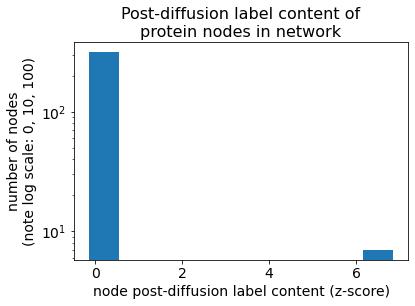

In [1005]:
#fig = plt.figure()
#plt.hist(df.final_label)
#plt.yscale('log')

fig = plt.figure()
fig.set_size_inches(6, 4)

plt.rc('font', size=14)
plt.rc('axes', titlesize=16)

plt.xlabel('node post-diffusion label content (z-score)')
plt.ylabel('number of nodes\n(note log scale: 0, 10, 100)')
plt.title('Post-diffusion label content of\nprotein nodes in network')



plt.hist(df.zscore)
plt.yscale('log')
plt.background = 'black'

plt.savefig('assets/post_diffusion_pic.png')


plt.show()

In [945]:
df['zscore']

0     -0.149308
1     -0.149308
2     -0.149308
3     -0.149308
4     -0.149308
         ...   
317   -0.149308
318   -0.149308
319   -0.149308
320   -0.149308
321   -0.149308
Name: zscore, Length: 321, dtype: float64

In [830]:
df.sort_values('rank', ascending=False)[:50]

,protein,initial_label,final_label,rank
52,CDK7,1.0,1.005152,322.0
269,RPS6KA3,1.0,1.002644,321.0
173,MAPK9,1.0,1.002564,320.0
61,CSNK1A1,1.0,1.002552,319.0
268,RPS6KA1,1.0,1.000007,318.0
53,CDK9,1.0,0.997376,317.0
64,CSNK2A1,1.0,0.997326,316.0
229,PLK3,1.0,0.997222,315.0
48,CDK2,1.0,0.997173,314.0
119,IKBKB,1.0,0.994744,313.0


In [155]:
loo.get_auc()

0.33798076923076925

In [164]:
help(sim.sim_matrix)

Help on SimilarityMatrix in module similarity object:

class SimilarityMatrix(builtins.object)
 |  SimilarityMatrix(sim_matrix, protein_list)
 |  
 |  Similairity matrix and its protein ids.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sim_matrix, protein_list)
 |      Inits the similarity matrix container.
 |      
 |      Parameters
 |      ----------
 |      sim_matrix : numpy 2d array
 |          Matrix containing protein-protein GO term similarity scores, so that
 |          sim_matrix[i, j] contains similarity score for proteins i and j.
 |      
 |      protein_list : list[str]
 |          List of proteins in the matrix, sorted so that
 |          row (column) i in sim_matrix corresponds to protein[i].
 |  
 |  save_as_pickle(self, save_path)
 |      Pickles self to at given file path.
 |      
 |      Parameters
 |      ----------
 |      save_path : str
 |          Desired file path of the output pickle file.
 |  
 |  threshold_matrix(self, n=None)
 |      Converts s

In [179]:
len(sim.sim_matrix.adj_matrix.col)

6327

In [181]:
330 * (np.ceil(np.sqrt(330)))

6270.0

In [ ]:
#array([  6,   7,  11, ..., 332, 332, 332], dtype=int32)
#array([330, 329, 326, ..., 127, 130, 175], dtype=int32)

In [724]:
fdf = pd.read_csv('results/old_ffs_flat_matrix', delimiter='\t')

In [740]:
fdf2 = fdf.loc[fdf.score != 'None']

In [747]:
fdf2.score = fdf2.score.astype(float)

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


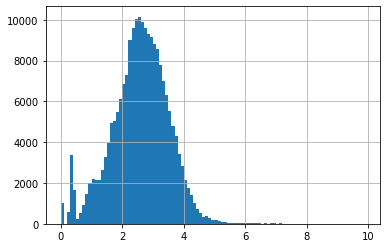

In [782]:
fdf2.score.hist(bins=np.arange(0,10,0.1))

In [787]:
print(len(fdf2.score))
print(len(fdf.score))
print(515*0.8)

209764
259081
412.0


In [756]:
a = sim.sim_matrix.sim_matrix.flatten()

89102


(0.0, 5000.0)

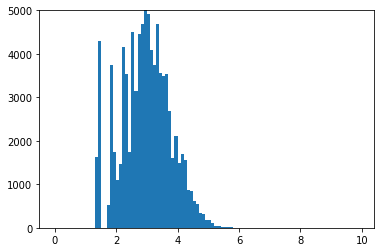

In [784]:
x = a.A1
x = list(filter(lambda a: a != 0, x))
print(len(x))
x = plt.hist(x, bins=np.arange(0,10,0.1))
plt.ylim([0,5000])

In [768]:
list(a.A1)

[0.0,
 3.6482654971149318,
 2.895342534852098,
 3.048459519758935,
 3.048459519758935,
 2.99405494218493,
 1.8412185274993118,
 2.867828018222311,
 3.048459519758935,
 4.429069745864155,
 3.6482654971149318,
 2.3243366763085453,
 3.048459519758935,
 2.2762195570058537,
 2.63688412729831,
 3.048459519758935,
 2.86329135321299,
 2.895342534852098,
 2.895342534852098,
 1.4874962046158593,
 4.118563858316296,
 2.23154595363422,
 3.6482654971149318,
 3.048459519758935,
 3.048459519758935,
 2.895342534852098,
 2.613169853197868,
 3.048459519758935,
 3.6482654971149318,
 2.99405494218493,
 2.906031362838258,
 2.895342534852098,
 1.8286895032219814,
 2.99405494218493,
 3.6482654971149318,
 2.99405494218493,
 2.99405494218493,
 2.99405494218493,
 1.9677522201842135,
 2.895342534852098,
 3.6482654971149318,
 2.3243366763085453,
 2.2977672289052244,
 2.99405494218493,
 3.048459519758935,
 2.867828018222311,
 2.906031362838258,
 2.579659365659874,
 2.371437198505814,
 2.867828018222311,
 3.6482654